## Make maps of the cluster computations

In [2]:
%matplotlib inline

In [3]:
import warnings

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import bottleneck as bn
import hvplot.xarray

import gsw
import cmocean.cm as cm
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

sns.set(style='ticks', context='paper', palette='colorblind',font_scale=1.3)
mpl.rc('figure', dpi=100, figsize=[11, 5])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

warnings.simplefilter('ignore')

#### Functions

In [87]:
def non_nan(array):
    lon = datm.lon.values.flatten()
    lat = datm.lat.values.flatten()
    ar = datm[array].values.flatten()

    mask = np.isfinite(lon) & np.isfinite(lat) & np.isfinite(ar)
    lon = lon[mask]
    lat = lat[mask]
    ar = ar[mask]
    return lon,lat,ar

def grid_da(xi,yi,array,method='linear'):
    ''' Grid cluster data onto regular grid
    '''
    from scipy.interpolate import griddata

    lon = datm.lon.values.flatten()
    lat = datm.lat.values.flatten()
    ar = datm[array].values.flatten()

    mask = np.isfinite(lon) & np.isfinite(lat) & np.isfinite(ar)
    lon = lon[mask]
    lat = lat[mask]
    ar = ar[mask]
    
    zi = griddata((lon, lat), ar, (xi[None,:], yi[:,None]), method=method )
    return zi

def alphabet(ax):
    for j, axx in enumerate(ax):
        axx.annotate(chr(j+65), (0, 1.02),
                     xycoords='axes fraction',
                     weight='bold')
        
def annotate_stats(array,ax,**kwargs):
    from scipy.stats import skew
    
    test = datm[array].values.flatten()
    sk,mean= skew(test[np.isfinite(test)]),np.nanmean(test)
    return ax.annotate(rf'sk: {sk:2.2f}'+'\n'+rf'm: {mean:2.2f}',(0.60,0.75), xycoords='axes fraction', **kwargs)

def wrap(test, deg=True):
    if deg:
        phases = (( -test + 180) % (2.0 * 180 ) - 180) * -1.0
    else:
        phases = (( -test + np.pi) % (2.0 * np.pi ) - np.pi) * -1.0
    return phases

#### Main program

In [152]:
dat = xr.open_mfdataset('../data/clusters/combinations_lt_10_*.nc',concat_dim='clusters',)

dat['angle'] = wrap(dat.angle, deg=True).pipe(np.radians)
# dat['angle'] -= dat.angle.mean(dim='clusters')
dat['normal'] = dat.ux-dat.vy 
dat['shearing'] = dat.vx+dat.uy  

dat['shear_angle'] = 0.5*np.arctan2(dat.shearing, dat.normal)
dat['shear_angle'] = wrap(dat.shear_angle, deg=False)

datm = dat.mean(dim='id')
datm = datm.sel(time=slice('2015-09-02','2015-09-14'))
datm['sigma'] =  (('clusters','time'),gsw.density.rho(datm.sal,datm.sst,0)-1000)
# datm = datm.resample(time='2H').mean()

In [96]:
xi = np.linspace(87.75,89.5, 40)
yi = np.linspace(15.75,17.5, 32)
zvort = grid_da(xi,yi,'vort')

In [97]:
xi = np.linspace(87.75,89.5, 40)
yi = np.linspace(15.75,17.5, 32)
zsigma = grid_da(xi,yi,'sigma')

In [98]:
fullpage = tuple( np.array([19.0,23.0])/2.54 )
quarterpage = tuple( np.array([9.5,11.5])/2.54 )
halfpage_hor = tuple( np.array([19.0,11.5])/2.54 )
halfpage_ver = tuple( np.array([9.5,23.0])/2.54 )

KeyboardInterrupt: 

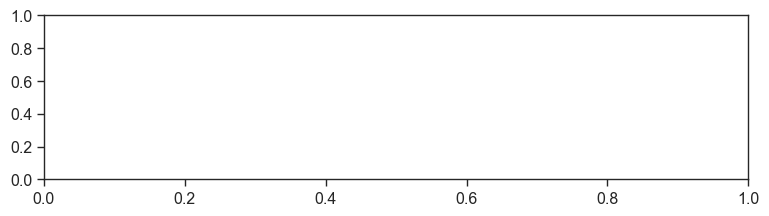

In [90]:
f = plt.figure(figsize=(15,10))
widths = [2 ,1]
heights = [1, 1, 1, 1]
spec = f.add_gridspec(ncols=2,
                      nrows=4,
                      width_ratios=widths,
                      height_ratios=heights,)

ax0 = f.add_subplot(spec[0, 0])
lon,lat,ar = non_nan('sigma')
h = ax0.hexbin(lon,lat,ar, cmap=cm.dense, gridsize=(40,32))
plt.colorbar(h, ax=ax0, label=r'$\sigma_0$ [kg m$^{-3}$]',pad=0.01)

ax0h = f.add_subplot(spec[0, 1])
datm.sigma.plot.hist(ax=ax0h, density=True, bins=30, color='k', range=(16,19))
ax0h.set_xlabel(r'$\sigma_0$')
ax0h.set_title(None)
ax0h.annotate('PDF',(0.05,0.9), xycoords='axes fraction',weight='semibold')

ax1 = f.add_subplot(spec[1, 0])
lon,lat,ar = non_nan('vort')
h = ax1.hexbin(lon,lat,ar,vmin=-0.6,vmax=0.6, cmap='RdBu_r', gridsize=(40,32))
plt.colorbar(h,ax=ax1, label=r'Vorticity $\zeta/f$',pad=0.01)

ax1h = f.add_subplot(spec[1, 1])
datm.vort.plot.hist(ax=ax1h, range=(-0.6,0.6), density=True, bins=30, color='k')
ax1h.set_xlabel(r'$\zeta/f$')
ax1h.set_title(None)
annotate_stats('vort',ax1h,fontsize=12)
ax1h.annotate('PDF',(0.05,0.9), xycoords='axes fraction',weight='semibold')

ax2 = f.add_subplot(spec[2, 0])
lon,lat,ar = non_nan('div')
h = ax2.hexbin(lon,lat,ar,vmin=-0.6,vmax=0.6, cmap='RdBu_r', gridsize=(40,32))
plt.colorbar(h,ax=ax2, label=r'Divergence $\delta/f$',pad=0.01)

ax2h = f.add_subplot(spec[2, 1])
datm.div.plot.hist(ax=ax2h, range=(-0.6,0.6), density=True, bins=30, color='k')
ax2h.set_xlabel(r'$\delta/f$')
ax2h.set_title(None)
annotate_stats('div',ax2h,fontsize=12)
ax2h.annotate('PDF',(0.05,0.9), xycoords='axes fraction',weight='semibold')

ax3 = f.add_subplot(spec[3, 0])
lon,lat,ar = non_nan('strain')
h = ax3.hexbin(lon,lat,ar,vmin=0,vmax=0.6, cmap=cm.deep_r, gridsize=(40,32))
plt.colorbar(h,ax=ax3, label=r'Lateral strain $S/f$',pad=0.01)

ax3h = f.add_subplot(spec[3, 1])
datm.strain.plot.hist(ax=ax3h, range=(0,0.6), density=True, bins=30, color='k')
ax3h.set_xlabel(r'$S$/f')
ax3h.set_title(None)
annotate_stats('strain',ax3h,fontsize=12)
ax3h.annotate('PDF',(0.05,0.9), xycoords='axes fraction',weight='semibold')

alphabet( [ax0,ax1,ax2,ax3])

spec.tight_layout(f)
spec.update(wspace=0.2, hspace=0.35)

plt.savefig('../figures/maps_hist.pdf')

In [ ]:
import gsw

In [ ]:
gsw.distance([87.75,90],[16,16])/1000/24

In [ ]:
gsw.distance([87.75,87.75],[16,17.6])/1000/17

In [99]:
def load_matfile(file):
    '''Read Matlab structure files and convert to numpy arrays'''
    import scipy.io as sio
    return sio.loadmat(file, struct_as_record=False, squeeze_me=True)

def datenum2datetime(datenum):
    '''Convert Matlab datenum to Python Datetime'''
    from datetime import datetime, timedelta
    return datetime.fromordinal(int(datenum)) + timedelta(days=datenum % 1) -\
        timedelta(days=366)

def datenum2datetime(matlab_datenum):
    from datetime import datetime, timedelta
    return datetime.fromordinal(int(matlab_datenum)) + timedelta(days=int(matlab_datenum)%1) - timedelta(days = 366)

In [100]:
mat = load_matfile('../data/smap/smap_2015.mat')
smap = mat['SMAP']
smap.xlon = np.tile(smap.lon,(120,1))
smap.xlat = np.transpose(np.tile(smap.lat,(160,1)))

In [101]:
datenum2datetime( smap.time[160] )

datetime.datetime(2015, 9, 12, 0, 0)

In [102]:
lonr,latr,arr = non_nan('sigma')
lonv,latv,arv = non_nan('vort')
lond,latd,ard = non_nan('div')
lons,lats,ars = non_nan('strain')

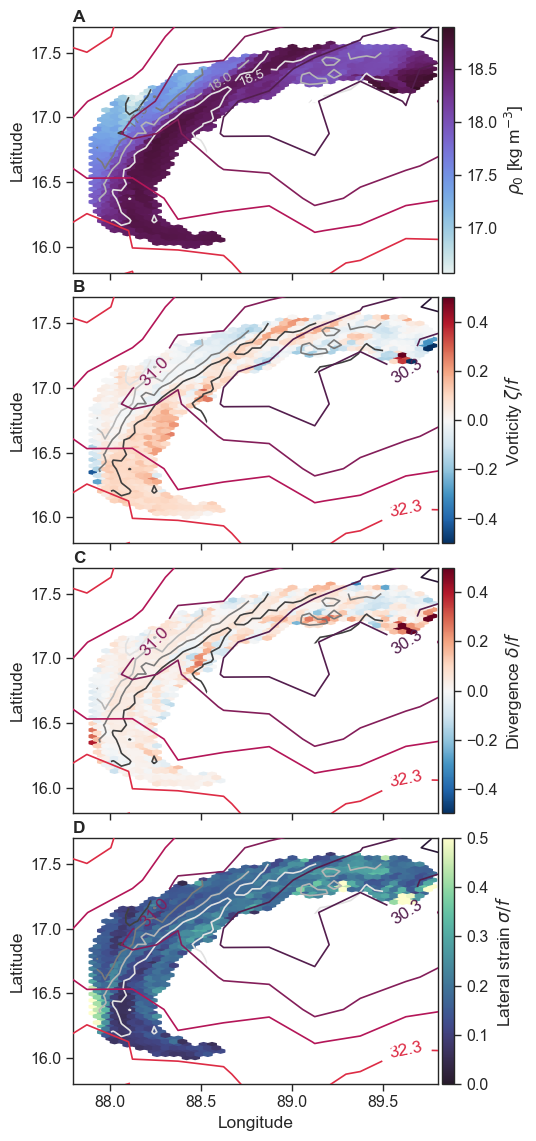

In [103]:
f, ax = plt.subplots(4,1, figsize=(5.6,14), sharex=True)
contour_levels=4
fmt = '%2.1f'
color='w'
t = 152
v= np.linspace(29, 35, 10)
cfunction = bn.nanmedian

h = ax[0].hexbin(lonr,latr,arr,mincnt=10, reduce_C_function=cfunction, cmap=cm.dense, gridsize=(40,32), rasterized=True)
plt.colorbar(h, ax=ax[0], label=r'$\rho_0$ [kg m$^{-3}$]',pad=0.01)
CS = ax[0].contour(xi,yi, zsigma,levels=contour_levels, cmap='Greys_r', rasterized=True)
ax[0].set_ylim(15.8,17.7)
ax[0].set_xlim(87.8,89.8)
ax[0].clabel(CS, CS.levels, inline=True,fmt=fmt, fontsize=10)
patch = patches.Circle((89.1,16.5),radius=0.61, fc=color, zorder=10)
ax[0].add_patch(patch)
ax[0].set_ylabel('Latitude')
lonx,latx = np.meshgrid(smap.lon,smap.lat)
ax[0].contour(lonx, latx,smap.sss[:,:,t], v, zorder=11, lw=0.5)

h = ax[1].hexbin(lonv,latv,arv,mincnt=10, reduce_C_function=cfunction, vmin=-0.5,vmax=0.5, cmap='RdBu_r', gridsize=(40,32), rasterized=True)
plt.colorbar(h,ax=ax[1], label=r'Vorticity $\zeta/f$',pad=0.01)
CS = ax[1].contour(xi,yi, zsigma,levels=contour_levels, cmap='Greys', rasterized=True)
ax[1].set_ylim(15.8,17.7)
ax[1].set_xlim(87.8,89.8)

patch = patches.Circle((89.1,16.5),radius=0.61, fc=color, zorder=10)
ax[1].add_patch(patch)
ax[1].set_ylabel('Latitude')
lonx,latx = np.meshgrid(smap.lon,smap.lat)
CS = ax[1].contour(lonx, latx,smap.sss[:,:,t], v, zorder=11, lw=0.5)
ax[1].clabel(CS, CS.levels, inline=True,fmt=fmt)

h = ax[2].hexbin(lond,latd,ard,mincnt=10,reduce_C_function=cfunction, vmin=-0.5,vmax=0.5, cmap='RdBu_r', gridsize=(40,32), rasterized=True)
plt.colorbar(h,ax=ax[2], label=r'Divergence $\delta/f$',pad=0.01)
CS = ax[2].contour(xi,yi, zsigma,levels=contour_levels, cmap='Greys', rasterized=True)
ax[2].set_ylim(15.8,17.7)
ax[2].set_xlim(87.8,89.8)

patch = patches.Circle((89.1,16.5),radius=0.61, fc=color, zorder=10)
ax[2].add_patch(patch)
ax[2].set_ylabel('Latitude')
lonx,latx = np.meshgrid(smap.lon,smap.lat)
CS = ax[2].contour(lonx, latx,smap.sss[:,:,t], v, zorder=11, lw=0.5)
ax[2].clabel(CS, CS.levels, inline=True,fmt=fmt)

h = ax[3].hexbin(lons,lats,ars,mincnt=10,reduce_C_function=cfunction, vmin=0,vmax=0.5, cmap=cm.deep_r, gridsize=(40,32), rasterized=True)
plt.colorbar(h,ax=ax[3], label=r'Lateral strain $\sigma/f$',pad=0.01)
CS = ax[3].contour(xi,yi, zsigma,levels=contour_levels, cmap='Greys_r', rasterized=True)
ax[3].set_ylim(15.8,17.7)
ax[3].set_xlim(87.8,89.8)

patch = patches.Circle((89.1,16.5),radius=0.61, fc=color, zorder=10)
ax[3].add_patch(patch);
ax[3].set_xticks([88,88.5,89,89.5])
ax[3].set_xlabel('Longitude')
ax[3].set_ylabel('Latitude')
lonx,latx = np.meshgrid(smap.lon,smap.lat)
CS = ax[3].contour(lonx, latx,smap.sss[:,:,t], v, zorder=11, lw=0.5)
ax[3].clabel(CS, CS.levels, inline=True,fmt=fmt)

alphabet(ax)

plt.subplots_adjust(hspace=0.1)
plt.savefig('../figures/kp_maps.pdf')

(87.8, 89.8)

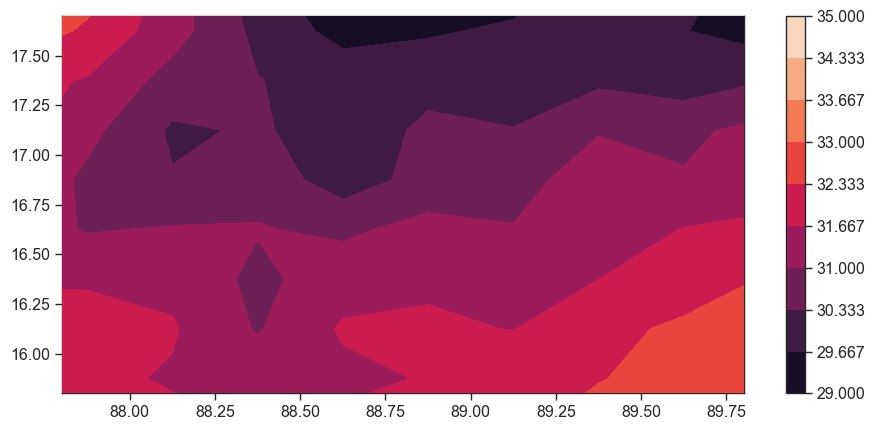

In [104]:
plt.contourf(lonx, latx,smap.sss[:,:,155], v, zorder=11)
plt.colorbar()
plt.ylim(15.8,17.7)
plt.xlim(87.8,89.8)

In [105]:
datenum2datetime( smap.time[152] )

datetime.datetime(2015, 9, 4, 0, 0)

In [148]:
from scipy.stats import circmean

In [ ]:
datm['shear_angle_m'] = datm.shear_angle.rolling(time=24).reduce(circmean, low=-np.pi, high=np.pi)

In [ ]:
lon_ang,lat_ang,ar_ang = non_nan('angle')
lon_sang,lat_sang,ar_sang = non_nan('shear_angle_m')

In [ ]:
f, ax = plt.subplots(2,1, figsize=(5,6))

h = ax[0].hexbin(lon_ang,lat_ang,np.degrees(ar_ang),mincnt=10, reduce_C_function=cfunction, cmap='twilight_shifted', vmin=-90, vmax=90, gridsize=(40,32), rasterized=True)
plt.colorbar(h,ax=ax[0], label=r'Angle from cluster deformation [rad]',pad=0.01)
CS = ax[0].contour(xi,yi, zsigma,levels=contour_levels, cmap='Greys', rasterized=True)
ax[0].set_ylim(15.8,17.7)
ax[0].set_xlim(87.8,89.8)

h = ax[1].hexbin(lon_sang,lat_sang,np.degrees(ar_sang),mincnt=10, reduce_C_function=cfunction, cmap='twilight_shifted', vmin=-90, vmax=90, gridsize=(40,32), rasterized=True)
plt.colorbar(h,ax=ax[1], label=r'Angle from arctan2(shearing/normal) [rad]',pad=0.01)
CS = ax[1].contour(xi,yi, zsigma,levels=contour_levels, cmap='Greys', rasterized=True)
ax[1].set_ylim(15.8,17.7)
ax[1].set_xlim(87.8,89.8)